In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import pandas as pd
import torch
from torch_geometric.data import Data
from rdkit import Chem
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from rdkit.Chem import rdchem

# Load dataset
df = pd.read_csv('ld50_zhu.tab', sep='\t')

# Helper function for one-hot encoding
def one_hot_encoding(value, choices):
    return [float(value == choice) for choice in choices]

# Atom feature function (enhanced)
def atom_features(atom):
    atom_type_list = ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'H', 'Unknown']
    hybridization_list = [
        rdchem.HybridizationType.SP,
        rdchem.HybridizationType.SP2,
        rdchem.HybridizationType.SP3,
        rdchem.HybridizationType.SP3D,
        rdchem.HybridizationType.SP3D2
    ]

    symbol = atom.GetSymbol()
    symbol = symbol if symbol in atom_type_list else 'Unknown'

    features = []
    features += one_hot_encoding(symbol, atom_type_list)
    features += one_hot_encoding(atom.GetDegree(), list(range(6)))
    features.append(atom.GetFormalCharge())
    features += one_hot_encoding(atom.GetHybridization(), hybridization_list)
    features.append(float(atom.GetIsAromatic()))
    features += one_hot_encoding(atom.GetNumImplicitHs(), list(range(5)))
    features += one_hot_encoding(atom.GetChiralTag(), [
        rdchem.ChiralType.CHI_UNSPECIFIED,
        rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        rdchem.ChiralType.CHI_OTHER
    ])
    features.append(float(atom.IsInRing()))
    features.append(atom.GetMass() * 0.01)  # Scaled atomic mass

    return torch.tensor(features, dtype=torch.float)

# SMILES to graph (no edge features)
def mol_to_graph_data(smiles, label):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])

    edge_index = []

    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    y = torch.tensor([label], dtype=torch.float)
    return Data(x=x, edge_index=edge_index, y=y)

# Convert all data
graph_data_list = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    data = mol_to_graph_data(row['X'], row['Y'])
    if data:
        graph_data_list.append(data)

# Split dataset
train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

class GCNRegressor(nn.Module):
    def __init__(self, num_node_features, hidden_dim=64):
        super(GCNRegressor, self).__init__()

        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)

        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)

        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = BatchNorm(hidden_dim)

        self.dropout = nn.Dropout(0.3)

        # Fully connected regression head
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x, edge_index, batch):
        # First GCN block
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second GCN block
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Third GCN block with residual connection
        x_res = x
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x + x_res)
        x = self.dropout(x)

        # Graph-level pooling
        x = global_mean_pool(x, batch)

        # Regression head
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)


def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out.view(-1), batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out.view(-1), batch.y.view(-1))
            total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_node_features = graph_data_list[0].x.shape[1]

model = GCNRegressor(num_node_features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []
val_losses = []

for epoch in range(1, 51):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch:03d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')


100%|██████████| 7385/7385 [00:06<00:00, 1083.32it/s]


Epoch 001: Train Loss = 1.2989, Val Loss = 0.6722
Epoch 002: Train Loss = 0.6880, Val Loss = 0.6936
Epoch 003: Train Loss = 0.6441, Val Loss = 0.6492
Epoch 004: Train Loss = 0.6260, Val Loss = 0.5770
Epoch 005: Train Loss = 0.6252, Val Loss = 0.6472
Epoch 006: Train Loss = 0.6018, Val Loss = 0.5726
Epoch 007: Train Loss = 0.6085, Val Loss = 0.6949
Epoch 008: Train Loss = 0.6019, Val Loss = 0.6570
Epoch 009: Train Loss = 0.5776, Val Loss = 0.5028
Epoch 010: Train Loss = 0.5738, Val Loss = 0.5518
Epoch 011: Train Loss = 0.5746, Val Loss = 0.5064
Epoch 012: Train Loss = 0.5559, Val Loss = 0.5761
Epoch 013: Train Loss = 0.5576, Val Loss = 0.5719
Epoch 014: Train Loss = 0.5511, Val Loss = 0.6106
Epoch 015: Train Loss = 0.5417, Val Loss = 0.5369
Epoch 016: Train Loss = 0.5377, Val Loss = 0.5337
Epoch 017: Train Loss = 0.5273, Val Loss = 0.5051
Epoch 018: Train Loss = 0.5175, Val Loss = 0.4812
Epoch 019: Train Loss = 0.5306, Val Loss = 0.5060
Epoch 020: Train Loss = 0.5230, Val Loss = 0.4673


📊 Evaluation Metrics on Test Set:
MAE  = 0.4628
MSE  = 0.3926
RMSE = 0.6266
R²   = 0.5605


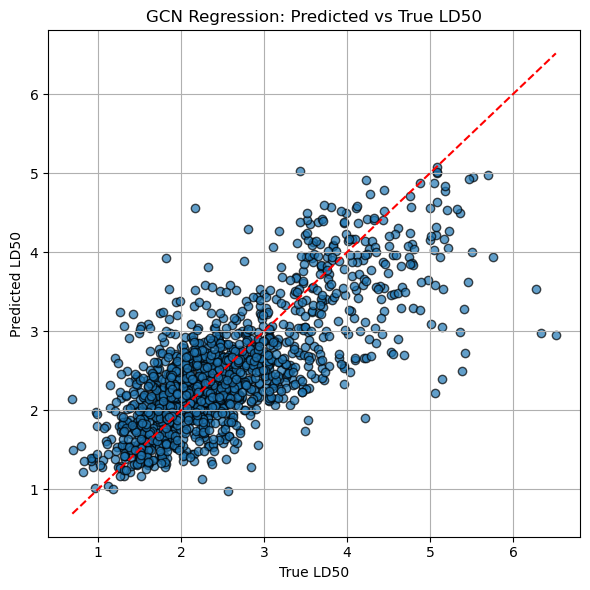

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def get_predictions(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch.x, batch.edge_index, batch.batch).view(-1)
            y_true.extend(batch.y.view(-1).cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = get_predictions(model, test_loader, device)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"📊 Evaluation Metrics on Test Set:")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True LD50")
plt.ylabel("Predicted LD50")
plt.title("GCN Regression: Predicted vs True LD50")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model_save_path = "gcn_regressor_model_50_without_edge_features.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to gcn_regressor_model_50_without_edge_features.pth
